## Socioeconomic Conditions and Police Activity by Census Tract in Boston
Author: Dante Lambros 
Date: January, 2026

Overview
This project examines how per-capita police incident rates vary across Boston census tracts with different poverty levels. I used Boston Police incident data and U.S. Census American Community Survey (ACS) estimates, my analysis provides a descriptive, tract level view of spatial patterns in public safety and socioeconomic context.

## Data Sources: 

Boston Police Department Crime Incident Reports (2024)
Public incident-level records including date, location, and offense type.

U.S. Census Bureau – American Community Survey (ACS) 5-Year Estimates 
#Census tract–level poverty rate estimates.

U.S. Census TIGER/Line Shapefiles  
Geographic boundaries for Massachusetts census tracts.


## Methods

Police incidents were aggregated to the census tract level and normalized by tract population to produce per-capita incident rates. Tracts with very small residential populations were excluded to improve rate stability, and extreme values were winsorized.

Poverty rates were obtained from ACS 5-year estimates and merged using census tract GEOIDs. The analysis is descriptive in nature.

In [4]:
%pip install pandas geopandas matplotlib census us shapely pyproj



Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from census import Census
import us


In [6]:
crime = pd.read_csv(
    "/Users/dante/Documents/boston_crime.csv",
    low_memory=False
)

print(crime.head().to_string())

   _id INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  SHOOTING        OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR  UCR_PART         STREET        Lat       Long                                  Location
0    1       232007173          3115                 NaN    INVESTIGATE PERSON       B3                        0  2023-01-27 22:44:00+00  2023      1   Friday       22       NaN       FAVRE ST  42.271661 -71.099535  (42.271661031027065, -71.09953455161765)
1    2       232004454          3301                 NaN        VERBAL DISPUTE       B2            316         0  2023-01-17 20:21:00+00  2023      1   Tuesday      20       NaN      HAROLD ST  42.312596 -71.092876    (42.3125962960786, -71.09287583752645)
2    3       232006290          3115                 NaN    INVESTIGATE PERSON       A1                        0  2023-01-24 00:00:00+00  2023      1   Tuesday       0       NaN     HANOVER ST  42.365699 -71.052892    (42.3656993

In [7]:
import pandas as pd

crime = pd.read_csv(
    "/Users/dante/Documents/boston_crime.csv",
    low_memory=False
)

crime['OCCURRED_ON_DATE'] = pd.to_datetime(
    crime['OCCURRED_ON_DATE'],
    errors='coerce'
)

crime_2024 = crime[
    (crime['OCCURRED_ON_DATE'] >= '2024-01-01') &
    (crime['OCCURRED_ON_DATE'] < '2025-01-01')
].copy()

len(crime_2024)


79081

In [8]:
import geopandas as gpd

crime_gdf = gpd.GeoDataFrame(
    crime_2024,
    geometry=gpd.points_from_xy(
        crime_2024["Long"],
        crime_2024["Lat"]
    ),
    crs="EPSG:4326"
)

_ = crime_gdf.head()



In [9]:
#sanity check
crime_gdf.geometry.isna().sum()


0

In [10]:
# Load Massachusetts census tracts
tracts = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_25_tract.zip"
)

# Reproject to match crime data
tracts = tracts.to_crs(crime_gdf.crs)

tracts.head(3).to_string()


'  STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ     NAME              NAMELSAD  MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [11]:
boston_tracts = tracts[
    (tracts["STATEFP"] == "25") &
    (tracts["COUNTYFP"] == "025")
].copy()

boston_tracts.shape


(235, 14)

In [12]:
crime_with_tracts = gpd.sjoin(
    crime_gdf,
    boston_tracts[["GEOID", "geometry"]],
    how="inner",
    predicate="within"
)

crime_with_tracts.shape


(74672, 21)

In [13]:
from census import Census
import pandas as pd
import os

# 1) Aggregate incidents by tract
incidents_by_tract = (
    crime_with_tracts
    .groupby("GEOID")
    .size()
    .reset_index(name="incident_count")
)

# 2) ACS poverty using detailed table B17001 (robust)
#    B17001_001E = total population for whom poverty status is determined
#    B17001_002E = population below poverty level
c = Census(os.getenv("CENSUS_API_KEY"))

acs = c.acs5.state_county_tract(
    fields=("NAME", "B17001_001E", "B17001_002E"),
    state_fips="25",
    county_fips="025",
    tract="*",
    year=2022  # <-- set explicitly; we can change later if you want
)

acs_df = pd.DataFrame(acs)

acs_df["GEOID"] = acs_df["state"] + acs_df["county"] + acs_df["tract"]

# Convert to numeric (sometimes comes in as strings)
acs_df["B17001_001E"] = pd.to_numeric(acs_df["B17001_001E"], errors="coerce")
acs_df["B17001_002E"] = pd.to_numeric(acs_df["B17001_002E"], errors="coerce")

acs_df["poverty_rate"] = 100 * (acs_df["B17001_002E"] / acs_df["B17001_001E"])

poverty_df = acs_df[["GEOID", "poverty_rate"]].dropna()

# 3) Merge
analysis_df = incidents_by_tract.merge(poverty_df, on="GEOID", how="inner")

# 4) Correlation
analysis_df[["incident_count", "poverty_rate"]].corr()
print(analysis_df[["incident_count", "poverty_rate"]].corr().to_string())



                incident_count  poverty_rate
incident_count        1.000000      0.064926
poverty_rate          0.064926      1.000000


In [14]:
# poverty_df with population included
poverty_df2 = acs_df[["GEOID", "B17001_001E", "poverty_rate"]].dropna().copy()
poverty_df2 = poverty_df2.rename(columns={"B17001_001E": "population"})

analysis_df2 = incidents_by_tract.merge(poverty_df2, on="GEOID", how="inner")

analysis_df2["incidents_per_1000"] = 1000 * analysis_df2["incident_count"] / analysis_df2["population"]

# Print outputs as plain text (avoids the notebook HTML rendering bug)
print(analysis_df2[["incidents_per_1000", "poverty_rate"]].corr().to_string())
print()
print(analysis_df2[["incidents_per_1000", "poverty_rate"]].describe().to_string())



                    incidents_per_1000  poverty_rate
incidents_per_1000            1.000000     -0.114796
poverty_rate                 -0.114796      1.000000

       incidents_per_1000  poverty_rate
count          198.000000    198.000000
mean           353.881156     18.716105
std           2032.425241     14.541293
min              8.522727      0.000000
25%             49.073864      7.836430
50%             81.046128     15.822060
75%            131.139009     27.602679
max          24000.000000     90.857143


In [15]:
import numpy as np

df = analysis_df2.copy()

# 1) Filter out very small-population tracts
# Threshold options: 500 is conservative; 1000 is stricter.
df = df[df["population"] >= 500].copy()

# Recompute per-1000 after filtering (good hygiene)
df["incidents_per_1000"] = 1000 * df["incident_count"] / df["population"]

# 2) Winsorize the incident rate to reduce distortion from outliers
p1 = df["incidents_per_1000"].quantile(0.01)
p99 = df["incidents_per_1000"].quantile(0.99)
df["incidents_per_1000_w"] = df["incidents_per_1000"].clip(lower=p1, upper=p99)

print("Rows after pop filter:", df.shape[0])
print("incidents_per_1000 quantiles (raw):")
print(df["incidents_per_1000"].quantile([0, .01, .05, .5, .95, .99, 1]).to_string())

print("\nCorrelation (winsorized rate vs poverty):")
print(df[["incidents_per_1000_w", "poverty_rate"]].corr().to_string())


Rows after pop filter: 188
incidents_per_1000 quantiles (raw):
0.00     11.279521
0.01     20.518468
0.05     30.556872
0.50     77.631893
0.95    414.140061
0.99    716.121950
1.00    927.852349

Correlation (winsorized rate vs poverty):
                      incidents_per_1000_w  poverty_rate
incidents_per_1000_w              1.000000      0.208258
poverty_rate                      0.208258      1.000000


In [16]:
# Build GeoDataFrame for mapping (Boston tracts + analysis variables)

map_gdf = boston_tracts[["GEOID", "geometry"]].merge(
    df[["GEOID", "poverty_rate", "incidents_per_1000_w"]],
    on="GEOID",
    how="inner"
)

map_gdf.shape


(188, 4)

In [17]:
#Results

#After normalizing police incident counts by population and addressing instability in small census tracts, a modest positive association is observed between neighborhood poverty rates and per-capita police incident levels. The correlation between poverty rate and winsorized incidents per 1,000 residents is approximately 0.21.

#Spatial patterns show areas where higher poverty and higher per-capita police activity overlap, as well as substantial variation across the city. Several higher-poverty tracts exhibit relatively lower incident rates, and some lower-poverty tracts exhibit higher rates, indicating that the relationship is not uniform.


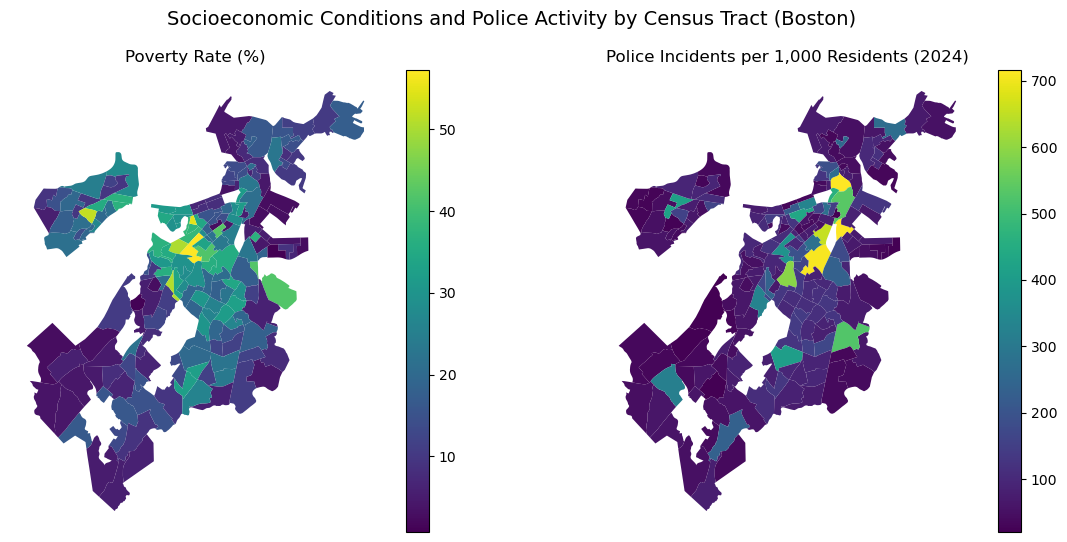

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left map: Poverty rate
map_gdf.plot(
    column="poverty_rate",
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Poverty Rate (%)")
axes[0].set_axis_off()

# Right map: Police incidents per capita
map_gdf.plot(
    column="incidents_per_1000_w",
    legend=True,
    ax=axes[1]
)
axes[1].set_title("Police Incidents per 1,000 Residents (2024)")
axes[1].set_axis_off()

plt.suptitle(
    "Socioeconomic Conditions and Police Activity by Census Tract (Boston)",
    fontsize=14
)
plt.show()


In [19]:
# Conclusion

#This descriptive analysis finds that higher-poverty census tracts in Boston tend to experience higher per-capita levels of recorded police incidents, though the relationship is modest and spatially uneven. The results highlight how population normalization and treatment of extreme values shape observed patterns in public safety data. While the analysis does not establish causality, it suggests that socioeconomic context is relevant when interpreting how police activity is distributed across neighborhoods for policy and planning purposes.
